# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

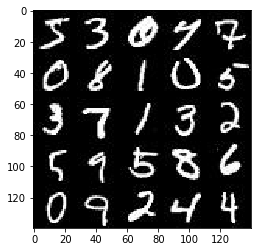

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

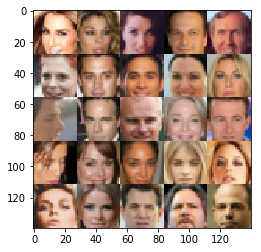

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/zhuweiping/miniconda2/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_ph = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z_ph = tf.placeholder(tf.float32, shape=(None, z_dim))
    lr_ph = tf.placeholder(tf.float32)
    return input_ph, z_ph, lr_ph


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512, activation=None)

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', activation=None)
        
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)

    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, out_channel_dim = data_shape
    input_ph, z_ph, lr_ph = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_ph, z_ph, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_ph, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                sess.run(d_train_opt, feed_dict={input_ph: batch_images, z_ph: batch_z, lr_ph:learning_rate})
                sess.run(g_train_opt, feed_dict={z_ph: batch_z, input_ph: batch_images, lr_ph:learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({z_ph: batch_z, input_ph: batch_images})
                    train_loss_g = g_loss.eval({z_ph: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % batch_size == 0:
                    show_generator_output(sess, 25, z_ph, out_channel_dim, data_image_mode)   
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4412... Generator Loss: 0.5107
Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 1.4796
Epoch 1/2... Discriminator Loss: 1.0775... Generator Loss: 0.9004
Epoch 1/2... Discriminator Loss: 1.3020... Generator Loss: 0.6314
Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 0.5805
Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 0.9518... Generator Loss: 1.2808
Epoch 1/2... Discriminator Loss: 1.1138... Generator Loss: 0.5383
Epoch 1/2... Discriminator Loss: 0.9535... Generator Loss: 2.1857
Epoch 1/2... Discriminator Loss: 0.8829... Generator Loss: 2.6080
Epoch 1/2... Discriminator Loss: 0.5111... Generator Loss: 2.1487
Epoch 1/2... Discriminator Loss: 0.4874... Generator Loss: 1.4652


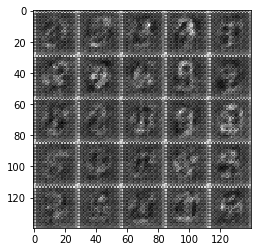

Epoch 1/2... Discriminator Loss: 0.3984... Generator Loss: 2.2912
Epoch 1/2... Discriminator Loss: 0.3313... Generator Loss: 4.0661
Epoch 1/2... Discriminator Loss: 1.3318... Generator Loss: 0.4852
Epoch 1/2... Discriminator Loss: 1.6796... Generator Loss: 0.3009
Epoch 1/2... Discriminator Loss: 0.9054... Generator Loss: 2.0021
Epoch 1/2... Discriminator Loss: 1.0285... Generator Loss: 1.3021
Epoch 1/2... Discriminator Loss: 0.6604... Generator Loss: 1.8241
Epoch 1/2... Discriminator Loss: 0.7664... Generator Loss: 1.0650
Epoch 1/2... Discriminator Loss: 0.7343... Generator Loss: 1.7608
Epoch 1/2... Discriminator Loss: 0.6501... Generator Loss: 1.6440
Epoch 1/2... Discriminator Loss: 0.8479... Generator Loss: 2.2200
Epoch 1/2... Discriminator Loss: 0.5343... Generator Loss: 1.4768
Epoch 1/2... Discriminator Loss: 0.5445... Generator Loss: 1.9699


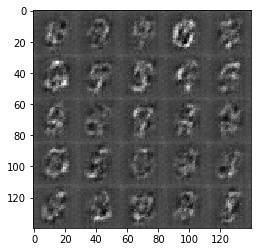

Epoch 1/2... Discriminator Loss: 0.5918... Generator Loss: 1.4536
Epoch 1/2... Discriminator Loss: 0.8135... Generator Loss: 3.1521
Epoch 1/2... Discriminator Loss: 0.5669... Generator Loss: 1.2530
Epoch 1/2... Discriminator Loss: 0.4556... Generator Loss: 1.5655
Epoch 1/2... Discriminator Loss: 0.7921... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 0.6001... Generator Loss: 1.0559
Epoch 1/2... Discriminator Loss: 0.7338... Generator Loss: 0.8356
Epoch 1/2... Discriminator Loss: 0.6777... Generator Loss: 2.8076
Epoch 1/2... Discriminator Loss: 0.4405... Generator Loss: 1.6304
Epoch 1/2... Discriminator Loss: 0.5170... Generator Loss: 1.4677
Epoch 1/2... Discriminator Loss: 0.4006... Generator Loss: 1.5497
Epoch 1/2... Discriminator Loss: 0.7464... Generator Loss: 4.3025
Epoch 1/2... Discriminator Loss: 0.7135... Generator Loss: 0.8372


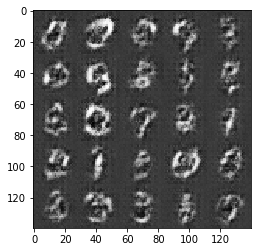

Epoch 1/2... Discriminator Loss: 1.2239... Generator Loss: 3.7140
Epoch 1/2... Discriminator Loss: 0.4030... Generator Loss: 1.8515
Epoch 1/2... Discriminator Loss: 0.3153... Generator Loss: 1.9120
Epoch 1/2... Discriminator Loss: 0.2335... Generator Loss: 2.3146
Epoch 1/2... Discriminator Loss: 0.6318... Generator Loss: 1.1646
Epoch 1/2... Discriminator Loss: 0.4025... Generator Loss: 1.4767
Epoch 1/2... Discriminator Loss: 0.9959... Generator Loss: 3.9367
Epoch 1/2... Discriminator Loss: 0.3167... Generator Loss: 2.0445
Epoch 2/2... Discriminator Loss: 0.4399... Generator Loss: 1.3536
Epoch 2/2... Discriminator Loss: 0.3055... Generator Loss: 2.2800
Epoch 2/2... Discriminator Loss: 0.3749... Generator Loss: 1.5926
Epoch 2/2... Discriminator Loss: 0.2992... Generator Loss: 1.9095
Epoch 2/2... Discriminator Loss: 0.2176... Generator Loss: 2.2212


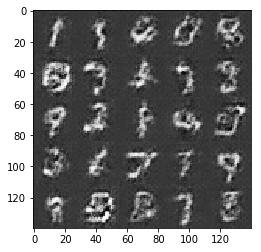

Epoch 2/2... Discriminator Loss: 0.1854... Generator Loss: 2.5793
Epoch 2/2... Discriminator Loss: 0.2053... Generator Loss: 2.3478
Epoch 2/2... Discriminator Loss: 1.0433... Generator Loss: 0.6204
Epoch 2/2... Discriminator Loss: 0.6046... Generator Loss: 1.2072
Epoch 2/2... Discriminator Loss: 0.5156... Generator Loss: 1.2790
Epoch 2/2... Discriminator Loss: 0.5520... Generator Loss: 1.1738
Epoch 2/2... Discriminator Loss: 0.4559... Generator Loss: 1.6144
Epoch 2/2... Discriminator Loss: 0.6207... Generator Loss: 1.0317
Epoch 2/2... Discriminator Loss: 0.3884... Generator Loss: 1.5204
Epoch 2/2... Discriminator Loss: 0.2661... Generator Loss: 2.0523
Epoch 2/2... Discriminator Loss: 0.2855... Generator Loss: 2.0250
Epoch 2/2... Discriminator Loss: 0.3258... Generator Loss: 2.1271
Epoch 2/2... Discriminator Loss: 2.1922... Generator Loss: 0.2065


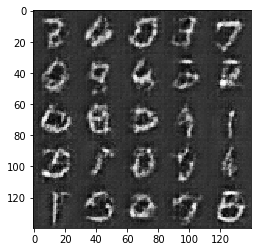

Epoch 2/2... Discriminator Loss: 0.5889... Generator Loss: 1.1224
Epoch 2/2... Discriminator Loss: 0.5843... Generator Loss: 1.0390
Epoch 2/2... Discriminator Loss: 0.3357... Generator Loss: 1.9128
Epoch 2/2... Discriminator Loss: 0.2315... Generator Loss: 2.6276
Epoch 2/2... Discriminator Loss: 0.3406... Generator Loss: 1.4840
Epoch 2/2... Discriminator Loss: 0.2664... Generator Loss: 2.7222
Epoch 2/2... Discriminator Loss: 0.0952... Generator Loss: 3.0975
Epoch 2/2... Discriminator Loss: 1.1459... Generator Loss: 0.5043
Epoch 2/2... Discriminator Loss: 0.4901... Generator Loss: 1.3697
Epoch 2/2... Discriminator Loss: 0.2226... Generator Loss: 2.3426
Epoch 2/2... Discriminator Loss: 0.1798... Generator Loss: 2.2065
Epoch 2/2... Discriminator Loss: 0.1689... Generator Loss: 2.4784


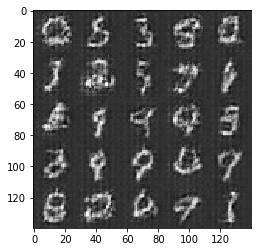

Epoch 2/2... Discriminator Loss: 0.1411... Generator Loss: 2.8304
Epoch 2/2... Discriminator Loss: 0.0912... Generator Loss: 3.2299
Epoch 2/2... Discriminator Loss: 0.0856... Generator Loss: 3.8221
Epoch 2/2... Discriminator Loss: 0.1349... Generator Loss: 2.7181
Epoch 2/2... Discriminator Loss: 0.1174... Generator Loss: 3.3586
Epoch 2/2... Discriminator Loss: 0.9878... Generator Loss: 0.7018
Epoch 2/2... Discriminator Loss: 0.5486... Generator Loss: 1.2163
Epoch 2/2... Discriminator Loss: 0.4008... Generator Loss: 1.5293
Epoch 2/2... Discriminator Loss: 0.2243... Generator Loss: 2.0534
Epoch 2/2... Discriminator Loss: 0.2201... Generator Loss: 2.1123
Epoch 2/2... Discriminator Loss: 0.4224... Generator Loss: 1.2958
Epoch 2/2... Discriminator Loss: 0.1140... Generator Loss: 3.2311
Epoch 2/2... Discriminator Loss: 0.0964... Generator Loss: 3.6345


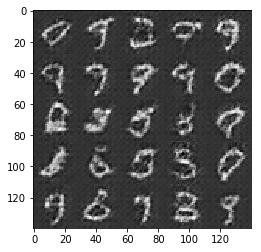

Epoch 2/2... Discriminator Loss: 1.3351... Generator Loss: 0.3980
Epoch 2/2... Discriminator Loss: 1.5047... Generator Loss: 1.2585
Epoch 2/2... Discriminator Loss: 1.3562... Generator Loss: 0.7462
Epoch 2/2... Discriminator Loss: 0.8606... Generator Loss: 0.9952


In [17]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 1.0340
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.4643
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 1.9632
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 2.0698
Epoch 1/1... Discriminator Loss: 0.2570... Generator Loss: 2.3287
Epoch 1/1... Discriminator Loss: 0.3216... Generator Loss: 1.7695
Epoch 1/1... Discriminator Loss: 1.8539... Generator Loss: 0.2553
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 0.6642


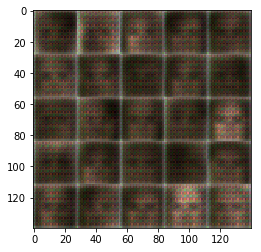

Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 7.0636
Epoch 1/1... Discriminator Loss: 0.3107... Generator Loss: 8.3209
Epoch 1/1... Discriminator Loss: 0.1290... Generator Loss: 3.6001
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 5.6256
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.3383
Epoch 1/1... Discriminator Loss: 0.5349... Generator Loss: 2.0496
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 1.8371
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 2.2725
Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 1.7298
Epoch 1/1... Discriminator Loss: 1.0196... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 2.8807... Generator Loss: 0.0852
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.5092


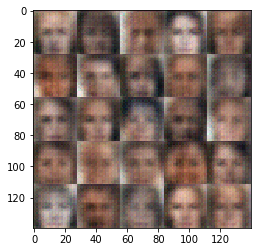

Epoch 1/1... Discriminator Loss: 1.7932... Generator Loss: 0.2348
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 5.5158
Epoch 1/1... Discriminator Loss: 0.3040... Generator Loss: 2.4016
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 2.3240
Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.3033
Epoch 1/1... Discriminator Loss: 2.7484... Generator Loss: 0.0848
Epoch 1/1... Discriminator Loss: 0.9594... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 0.2984... Generator Loss: 1.6704
Epoch 1/1... Discriminator Loss: 0.0578... Generator Loss: 8.7047
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.4293
Epoch 1/1... Discriminator Loss: 0.4739... Generator Loss: 2.3804
Epoch 1/1... Discriminator Loss: 0.0735... Generator Loss: 5.4123
Epoch 1/1... Discriminator Loss: 0.4425... Generator Loss: 5.1001


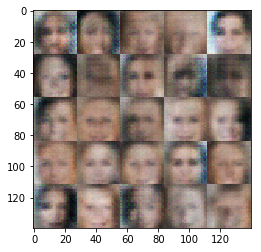

Epoch 1/1... Discriminator Loss: 0.0764... Generator Loss: 8.1774
Epoch 1/1... Discriminator Loss: 0.0949... Generator Loss: 3.1996
Epoch 1/1... Discriminator Loss: 0.2009... Generator Loss: 2.2136
Epoch 1/1... Discriminator Loss: 0.0442... Generator Loss: 5.0029
Epoch 1/1... Discriminator Loss: 0.0388... Generator Loss: 6.9483
Epoch 1/1... Discriminator Loss: 0.0841... Generator Loss: 3.5549
Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 5.9051
Epoch 1/1... Discriminator Loss: 0.3069... Generator Loss: 7.5271
Epoch 1/1... Discriminator Loss: 0.0367... Generator Loss: 6.6471
Epoch 1/1... Discriminator Loss: 0.1594... Generator Loss: 6.3567
Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 7.4437
Epoch 1/1... Discriminator Loss: 0.0579... Generator Loss: 5.1867
Epoch 1/1... Discriminator Loss: 0.0562... Generator Loss: 4.3871


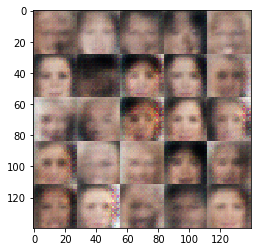

Epoch 1/1... Discriminator Loss: 0.0294... Generator Loss: 7.3875
Epoch 1/1... Discriminator Loss: 0.0469... Generator Loss: 3.6344
Epoch 1/1... Discriminator Loss: 0.1437... Generator Loss: 5.2224
Epoch 1/1... Discriminator Loss: 0.0468... Generator Loss: 3.6765
Epoch 1/1... Discriminator Loss: 0.0151... Generator Loss: 5.2768
Epoch 1/1... Discriminator Loss: 0.0677... Generator Loss: 6.6394
Epoch 1/1... Discriminator Loss: 0.0497... Generator Loss: 6.8625
Epoch 1/1... Discriminator Loss: 0.0436... Generator Loss: 4.0718
Epoch 1/1... Discriminator Loss: 0.0327... Generator Loss: 4.3473
Epoch 1/1... Discriminator Loss: 0.0227... Generator Loss: 5.8851
Epoch 1/1... Discriminator Loss: 0.0147... Generator Loss: 5.9613
Epoch 1/1... Discriminator Loss: 0.0254... Generator Loss: 7.2880
Epoch 1/1... Discriminator Loss: 0.0871... Generator Loss: 2.9557


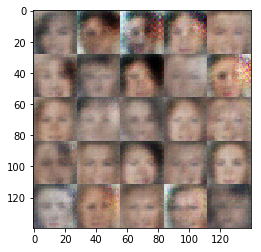

Epoch 1/1... Discriminator Loss: 0.0271... Generator Loss: 6.0449
Epoch 1/1... Discriminator Loss: 0.0146... Generator Loss: 6.8559
Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 0.0332... Generator Loss: 4.7040
Epoch 1/1... Discriminator Loss: 0.0505... Generator Loss: 6.4933
Epoch 1/1... Discriminator Loss: 0.0264... Generator Loss: 4.7091
Epoch 1/1... Discriminator Loss: 0.0263... Generator Loss: 7.1516
Epoch 1/1... Discriminator Loss: 0.0249... Generator Loss: 4.6548
Epoch 1/1... Discriminator Loss: 0.0145... Generator Loss: 5.1581
Epoch 1/1... Discriminator Loss: 0.0172... Generator Loss: 6.9228
Epoch 1/1... Discriminator Loss: 0.0142... Generator Loss: 5.5704
Epoch 1/1... Discriminator Loss: 0.0569... Generator Loss: 3.7746


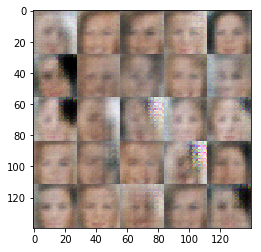

Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 3.9754
Epoch 1/1... Discriminator Loss: 0.1994... Generator Loss: 2.0543
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 5.8973
Epoch 1/1... Discriminator Loss: 0.0183... Generator Loss: 6.1989
Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 7.9344
Epoch 1/1... Discriminator Loss: 0.0082... Generator Loss: 6.2068
Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 4.8189
Epoch 1/1... Discriminator Loss: 0.0062... Generator Loss: 7.1180
Epoch 1/1... Discriminator Loss: 0.0452... Generator Loss: 3.7031
Epoch 1/1... Discriminator Loss: 0.0146... Generator Loss: 7.7236
Epoch 1/1... Discriminator Loss: 0.0123... Generator Loss: 7.6737
Epoch 1/1... Discriminator Loss: 0.0221... Generator Loss: 5.8171
Epoch 1/1... Discriminator Loss: 0.0090... Generator Loss: 7.9236


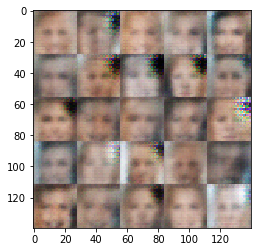

Epoch 1/1... Discriminator Loss: 0.0145... Generator Loss: 4.9750
Epoch 1/1... Discriminator Loss: 0.0094... Generator Loss: 7.1419
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.3286
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 4.4777
Epoch 1/1... Discriminator Loss: 0.0579... Generator Loss: 7.0920
Epoch 1/1... Discriminator Loss: 0.0749... Generator Loss: 4.8021
Epoch 1/1... Discriminator Loss: 0.1240... Generator Loss: 7.8565
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 1.3478
Epoch 1/1... Discriminator Loss: 0.0261... Generator Loss: 4.6065
Epoch 1/1... Discriminator Loss: 0.0683... Generator Loss: 6.9009
Epoch 1/1... Discriminator Loss: 0.0288... Generator Loss: 5.5256
Epoch 1/1... Discriminator Loss: 0.0127... Generator Loss: 5.7661
Epoch 1/1... Discriminator Loss: 0.0473... Generator Loss: 3.5162


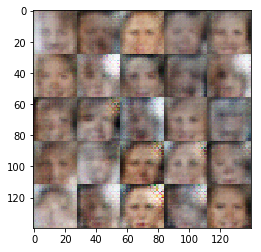

Epoch 1/1... Discriminator Loss: 0.0243... Generator Loss: 5.5089
Epoch 1/1... Discriminator Loss: 0.0491... Generator Loss: 4.1840
Epoch 1/1... Discriminator Loss: 0.0105... Generator Loss: 7.0703
Epoch 1/1... Discriminator Loss: 0.0788... Generator Loss: 9.1421
Epoch 1/1... Discriminator Loss: 0.0920... Generator Loss: 2.9704
Epoch 1/1... Discriminator Loss: 0.1956... Generator Loss: 2.0406
Epoch 1/1... Discriminator Loss: 0.0167... Generator Loss: 7.3533
Epoch 1/1... Discriminator Loss: 0.0727... Generator Loss: 4.2316
Epoch 1/1... Discriminator Loss: 0.0240... Generator Loss: 6.9234
Epoch 1/1... Discriminator Loss: 0.0638... Generator Loss: 8.7109
Epoch 1/1... Discriminator Loss: 0.0162... Generator Loss: 7.5297
Epoch 1/1... Discriminator Loss: 0.0067... Generator Loss: 6.2617
Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 6.9430


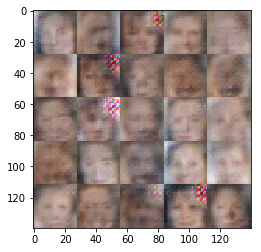

Epoch 1/1... Discriminator Loss: 0.0112... Generator Loss: 5.2713
Epoch 1/1... Discriminator Loss: 0.0098... Generator Loss: 7.3808
Epoch 1/1... Discriminator Loss: 0.0425... Generator Loss: 3.8025
Epoch 1/1... Discriminator Loss: 0.1931... Generator Loss: 1.9911
Epoch 1/1... Discriminator Loss: 0.0113... Generator Loss: 6.7440
Epoch 1/1... Discriminator Loss: 0.0130... Generator Loss: 8.1959
Epoch 1/1... Discriminator Loss: 0.0126... Generator Loss: 6.9068
Epoch 1/1... Discriminator Loss: 0.0824... Generator Loss: 3.7870
Epoch 1/1... Discriminator Loss: 0.0062... Generator Loss: 7.4672
Epoch 1/1... Discriminator Loss: 0.0215... Generator Loss: 6.5700
Epoch 1/1... Discriminator Loss: 0.2538... Generator Loss: 1.8112
Epoch 1/1... Discriminator Loss: 0.0131... Generator Loss: 8.2792
Epoch 1/1... Discriminator Loss: 0.0069... Generator Loss: 7.6632


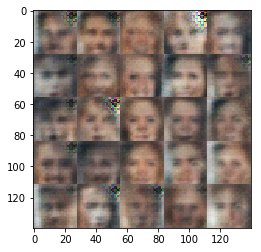

Epoch 1/1... Discriminator Loss: 0.0159... Generator Loss: 5.8668
Epoch 1/1... Discriminator Loss: 0.1134... Generator Loss: 2.7449
Epoch 1/1... Discriminator Loss: 0.0401... Generator Loss: 4.2509
Epoch 1/1... Discriminator Loss: 0.7929... Generator Loss: 9.0468
Epoch 1/1... Discriminator Loss: 0.0359... Generator Loss: 5.5311
Epoch 1/1... Discriminator Loss: 0.0355... Generator Loss: 4.2636
Epoch 1/1... Discriminator Loss: 0.0217... Generator Loss: 5.7861
Epoch 1/1... Discriminator Loss: 0.0806... Generator Loss: 3.8663
Epoch 1/1... Discriminator Loss: 0.0073... Generator Loss: 8.4941
Epoch 1/1... Discriminator Loss: 0.0058... Generator Loss: 6.7171
Epoch 1/1... Discriminator Loss: 0.0076... Generator Loss: 5.6452
Epoch 1/1... Discriminator Loss: 0.0065... Generator Loss: 7.2400


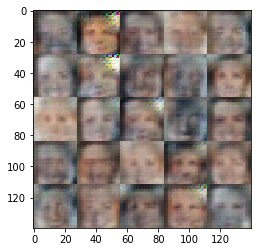

Epoch 1/1... Discriminator Loss: 0.0047... Generator Loss: 7.3904
Epoch 1/1... Discriminator Loss: 0.0125... Generator Loss: 5.1312
Epoch 1/1... Discriminator Loss: 0.0139... Generator Loss: 7.2813
Epoch 1/1... Discriminator Loss: 0.0084... Generator Loss: 7.7718
Epoch 1/1... Discriminator Loss: 0.0057... Generator Loss: 6.5531
Epoch 1/1... Discriminator Loss: 0.0083... Generator Loss: 5.6020
Epoch 1/1... Discriminator Loss: 0.0050... Generator Loss: 6.5514
Epoch 1/1... Discriminator Loss: 0.0101... Generator Loss: 7.2750
Epoch 1/1... Discriminator Loss: 0.0070... Generator Loss: 6.3938
Epoch 1/1... Discriminator Loss: 0.0099... Generator Loss: 5.5951
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 5.9952
Epoch 1/1... Discriminator Loss: 0.0080... Generator Loss: 5.4792
Epoch 1/1... Discriminator Loss: 0.0328... Generator Loss: 3.8561


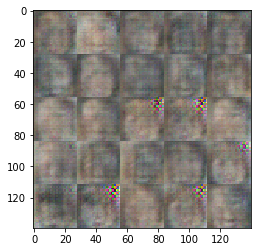

Epoch 1/1... Discriminator Loss: 0.0084... Generator Loss: 6.1395
Epoch 1/1... Discriminator Loss: 0.0208... Generator Loss: 4.6723
Epoch 1/1... Discriminator Loss: 0.0060... Generator Loss: 6.5800
Epoch 1/1... Discriminator Loss: 0.0034... Generator Loss: 7.8413
Epoch 1/1... Discriminator Loss: 0.0093... Generator Loss: 5.6058


In [18]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.